# PROJECT 2 : AIRLINE DYNAMIC PRICING

## GROUP 26

**Aditya Chawla (ac86589)**

**Anmol Agrawal (aa96674)**

**Mayank Gupta (mg66426)**

**Sharan Arora (sa44827)**

# Overbooking policies for Flight Tickets

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

%matplotlib inline

### Define the parameters needed for analysis

In [118]:
#defining the parameters

def get_params(C_num,F_num,O_num):

    pricing = {
        'cl': 300,  # Low price in coach
        'ch': 350,  # High price in coach
        'fl': 425,  # Low price in first class
        'fh': 500   # High price in first class
    }

    demand_probabilities = {
        'p_cl': 0.35,  # prob for low price in coach; 1-0.65
        'p_ch': 0.7,   # prob for high price in coach; 1-0.3
        'p_fl': 0.92,  # prob for low price in first class; 1-0.08
        'p_fh': 0.96,   # prob for high price in first class; 1-0.04
        'p_cl_fc_soldout' : 0.32, #soldout prob for low price in coach;1-0.68
        'p_ch_fc_soldout' : 0.67 #soldout for high price in coach;1-0.33
    }

    flight_details = {
        'delta': 1 / (1 + (0.17 / 365)),  # discount rate  
        't': 365,  # days until takeoff  
        'C_num': C_num,   # number of coach seats
        'F_num': F_num,   # number of first class seats
        'O_num': O_num    # number of overbooked seats
    }

    overbooking_costs = {
        'F_oc': 50,  # overbooking cost for Coach to First Class
        'E_oc': 425  # overbooking cost for coach passenger off the plane
    }


    # Counting possible state values
    num_coach_sales_states = len(np.arange(flight_details['C_num'] + flight_details['O_num'] + 1)) # all num of seats sold in coach
    num_first_class_sales_states = len(np.arange(flight_details['F_num'] + 1)) # all num of seats sold in First Class
    num_days_until_takeoff_states = len(np.arange(flight_details['t'] + 1)) # possible days until takeoff

    # Initializing value function and optimal choice variable
    value_function = np.zeros((num_coach_sales_states, num_first_class_sales_states, num_days_until_takeoff_states))
    optimal_choice = np.zeros((num_coach_sales_states, num_first_class_sales_states, num_days_until_takeoff_states))

    cost_matrix = np.zeros((num_coach_sales_states, num_first_class_sales_states)) # Initialize cost for various possibilities on the day of departure

    return_params = {"pricing":pricing, "demand_probabilities":demand_probabilities, "flight_details":flight_details, "overbooking_costs":overbooking_costs, 
                     "num_coach_sales_states":num_coach_sales_states,"num_first_class_sales_states":num_first_class_sales_states, "num_days_until_takeoff_states":num_days_until_takeoff_states,
                     "optimal_choice":optimal_choice, "value_function":value_function, "cost_matrix":cost_matrix}

    return return_params


In [119]:
def init_costmatrix(num_coach_sales_states,num_first_class_sales_states,C_num,F_num,overbooking_costs,flight_details):
    # Pre-compute the coach and first class indices arrays
    coach_indices = np.arange(num_coach_sales_states)
    first_class_indices = np.arange(num_first_class_sales_states)

    # Compute penalties for overbooking beyond available seats in first class
    coach_overbooking = np.maximum(coach_indices - C_num, 0)[:, None]  # Column vector
    first_class_underbooking = np.maximum(F_num - first_class_indices, 0)  # Row vector

    cost_matrix = np.where(
        coach_indices[:, None] <= flight_details["C_num"],
        0,
        np.where(
            coach_overbooking <= first_class_underbooking,
            coach_overbooking * overbooking_costs["F_oc"],
            (coach_overbooking - first_class_underbooking) * overbooking_costs["E_oc"] + first_class_underbooking * overbooking_costs["F_oc"]
        )
    )

    return cost_matrix

### Policy 1: Expected profit with 2 choices

In [120]:
def exp_rev_two_choices(C_num,F_num,O_num):

    #get all the params
    params = get_params(C_num,F_num,O_num)
    pricing = params["pricing"]
    demand_probabilities = params["demand_probabilities"]
    flight_details = params["flight_details"]
    overbooking_costs = params["overbooking_costs"]
    num_coach_sales_states = params["num_coach_sales_states"]
    num_first_class_sales_states = params["num_first_class_sales_states"]
    num_days_until_takeoff_states = params["num_days_until_takeoff_states"]
    optimal_choice = params["optimal_choice"]
    value_function = params["value_function"]
    cost_matrix = params["cost_matrix"]

    #Initialize cost matrix

    p_cl = demand_probabilities["p_cl"]
    p_ch = demand_probabilities["p_ch"]
    p_fl = demand_probabilities["p_fl"]
    p_fh = demand_probabilities["p_fh"]
    p_cl_s = demand_probabilities["p_cl_fc_soldout"]
    p_ch_s = demand_probabilities["p_ch_fc_soldout"]

    cost_matrix = init_costmatrix(num_coach_sales_states,num_first_class_sales_states,C_num,F_num,overbooking_costs,flight_details)

    # boundary/terminal condition to get optimal choice and value function
    
    for coach_index in range(num_coach_sales_states):
        for first_class_index in range(num_first_class_sales_states):
            if coach_index <= flight_details['C_num']:
                value_function[coach_index, :, num_days_until_takeoff_states - 1] = 0
            else:
                i_range = np.arange(coach_index + 1)
                j_range = np.arange(first_class_index + 1)
                prob_i = scipy.stats.binom.pmf(i_range, coach_index, 0.95)[:, None] # Shape (n, 1)
                prob_j = scipy.stats.binom.pmf(j_range, first_class_index, 0.97) # Shape (m,)

                # Calculate terminal cost using a 2D array (matrix) of probabilities and costs
                terminal_cost = 0
                for i in range(len(i_range)):
                    for j in range(len(j_range)):
                        terminal_cost += cost_matrix[i, j] * prob_i[i] * prob_j[j]
                
                value_function[coach_index, first_class_index, num_days_until_takeoff_states - 1] = -terminal_cost

    optimal_choice[:, :, num_days_until_takeoff_states - 1] = 0

    # iterate over the days until takeoff to get the optimal choice and value function
    for t in reversed(range(num_days_until_takeoff_states-1)):
        for c in range(num_coach_sales_states):
            for f in range(num_first_class_sales_states):
                
                if (c==flight_details['C_num']+flight_details['O_num']) & (f==flight_details["F_num"]): # if the flight is full (0 seats left)
                    value_function[c,f,t] = flight_details['delta']*value_function[c,f,t+1] # you can't make any more money
                    optimal_choice[c,f,t] = 0 # no tickets to sell
                    
                elif (f==flight_details["F_num"]) & (c!=flight_details['C_num']+flight_details['O_num']): # if there are no more first class seats left
                    val1 = (1-p_cl_s)*pricing["cl"] + flight_details['delta']*(p_cl_s*value_function[c,f,t+1] + (1-p_cl_s)*value_function[c+1,f,t+1]) # expected revenue: low price, low price + discounted expected value function next time
                    val2 = (1-p_cl_s)*pricing["cl"] + flight_details['delta']*(p_cl_s*value_function[c,f,t+1] + (1-p_cl_s)*value_function[c+1,f,t+1]) # expected revenue: low price, high price + discounted expected value function next time
                    val3 = (1-p_ch_s)*pricing["ch"]+ flight_details['delta']*(p_ch_s*value_function[c,f,t+1] + (1-p_ch_s)*value_function[c+1,f,t+1]) # expected revenue: high price, low price + discounted expected value function next time
                    val4 = (1-p_ch_s)*pricing["ch"] + flight_details['delta']*(p_ch_s*value_function[c,f,t+1] + (1-p_ch_s)*value_function[c+1,f,t+1]) # expected revenue from high price, high price + discounted expected value function next time

                    value_function[c,f,t]=max(val1, val2, val3, val4)
                    optimal_choice[c,f,t]=np.argmax([val1, val2, val3, val4])+1 
                
                elif (f!=flight_details["F_num"]) & (c==flight_details['C_num']+flight_details['O_num']): # if there are no more coach seats left
                    val1 = (1-p_fl)*pricing['fl'] + flight_details['delta']*(p_fl*value_function[c,f,t+1] + (1-p_fl)*value_function[c,f+1,t+1]) 
                    val2 = (1-p_fh)*pricing['fh'] + flight_details['delta']*(p_fh*value_function[c,f,t+1] + (1-p_fh)*value_function[c,f+1,t+1])
                    val3 = (1-p_fl)*pricing['fl'] + flight_details['delta']*(p_fl*value_function[c,f,t+1] + (1-p_fl)*value_function[c,f+1,t+1])
                    val4 = (1-p_fh)*pricing['fh'] + flight_details['delta']*(p_fh*value_function[c,f,t+1] + (1-p_fh)*value_function[c,f+1,t+1])

                    value_function[c,f,t]= value_function[c,f,t]=max(val1, val2, val3, val4)
                    optimal_choice[c,f,t]=np.argmax([val1, val2, val3, val4])+1

                else: # if there are still seats left in both classes
                    val1 = (1-p_cl)*pricing['cl'] + (1-p_fl)*pricing['fl'] + flight_details['delta']*(p_cl*p_fl*value_function[c,f,t+1] + (1-p_cl)*p_fl*value_function[c+1,f,t+1] +\
                                                                p_cl*(1-p_fl)*value_function[c,f+1,t+1] + (1-p_cl)*(1-p_fl)*value_function[c+1,f+1,t+1])
                    val2 = (1-p_cl)*pricing['cl'] + (1-p_fh)*pricing['fh'] + flight_details['delta']*(p_cl*p_fh*value_function[c,f,t+1] + (1-p_cl)*p_fh*value_function[c+1,f,t+1] +\
                                                                p_cl*(1-p_fh)*value_function[c,f+1,t+1] + (1-p_cl)*(1-p_fh)*value_function[c+1,f+1,t+1])
                    val3 = (1-p_ch)*pricing['ch'] + (1-p_fl)*pricing['fl'] + flight_details['delta']*(p_ch*p_fl*value_function[c,f,t+1] + (1-p_ch)*p_fl*value_function[c+1,f,t+1] +\
                                                                p_ch*(1-p_fl)*value_function[c,f+1,t+1] + (1-p_ch)*(1-p_fl)*value_function[c+1,f+1,t+1])
                    val4 = (1-p_ch)*pricing['ch'] + (1-p_fh)*pricing['fh'] + flight_details['delta']*(p_ch*p_fh*value_function[c,f,t+1] + (1-p_ch)*p_fh*value_function[c+1,f,t+1] +\
                                                                p_ch*(1-p_fh)*value_function[c,f+1,t+1] + (1-p_ch)*(1-p_fh)*value_function[c+1,f+1,t+1])

                    value_function[c,f,t]= value_function[c,f,t]=max(val1, val2, val3, val4)
                    optimal_choice[c,f,t]=np.argmax([val1, val2, val3, val4])+1

    return optimal_choice, value_function

In [238]:
#Expected profit if there are 100 coach seats, 20 first class seats and 5 overbooked seats
optimal_choice, value_function = exp_rev_two_choices(100,20,5)
print("Expected profit with 5 overbooked seats:",value_function[0,0,0])

Expected profit with 5 overbooked seats: 41886.15862419619


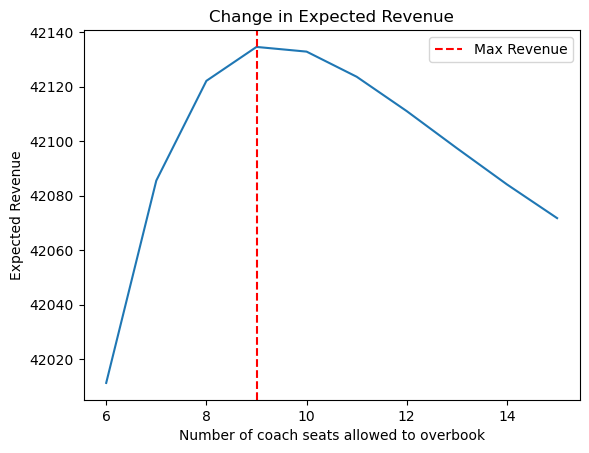

In [130]:
seats_overbooked_range = np.arange(6,16)
rev = np.zeros(len(seats_overbooked_range))
for i in range(len(seats_overbooked_range)):
    opt_choice, val = exp_rev_two_choices(100, 20, seats_overbooked_range[i])
    rev[i] = val[0,0,0]

# Plot of the expected profit with number of seats overbooked in Coach
seats_overbooked_range = np.arange(6, 16, 1)
plt.plot(seats_overbooked_range, rev)
plt.ylabel('Change in Expected Profit')
plt.xlabel('Number of coach seats allowed to overbook')
plt.title('Exptected Profit vs Number of Coach Seats Overbooked')
plt.xticks(seats_overbooked_range)
max_rev_index = np.argmax(rev)
plt.axvline(x=seats_overbooked_range[max_rev_index], color='r', linestyle='--', label='Max Profit')
plt.legend()
plt.show()

In [237]:
#Data frame with expected profits for each number of seats overbooked from 6 to 15
rev_df = pd.DataFrame(rev, index=seats_overbooked_range, columns=['Expected Profit'])
rev_df.index.name = "seats overbooked"
rev_df

,Expected Profit
seats overbooked,
6,42011.221060
7,42085.536156
8,42122.167269
9,42134.624830
10,42132.900382
11,42123.665936
12,42111.029670
13,42097.419510
14,42084.111570


Here we can observe that the maximum expected discounted profit is when we allow coach to be oversold by 9 seats

### Policy 2: Expected profit with 3 choices (option to offer no coach seat on any day)

In [185]:
def exp_rev_three_choices(C_num,F_num,O_num):
    
    #get all the params
    params = get_params(C_num,F_num,O_num)
    pricing = params["pricing"]
    demand_probabilities = params["demand_probabilities"]
    flight_details = params["flight_details"]
    overbooking_costs = params["overbooking_costs"]
    num_coach_sales_states = params["num_coach_sales_states"]
    num_first_class_sales_states = params["num_first_class_sales_states"]
    num_days_until_takeoff_states = params["num_days_until_takeoff_states"]
    optimal_choice = params["optimal_choice"]
    value_function = params["value_function"]
    cost_matrix = params["cost_matrix"]

    #Initialize cost matrix

    p_cl = demand_probabilities["p_cl"]
    p_ch = demand_probabilities["p_ch"]
    p_fl = demand_probabilities["p_fl"]
    p_fh = demand_probabilities["p_fh"]
    p_cl_s = demand_probabilities["p_cl_fc_soldout"]
    p_ch_s = demand_probabilities["p_ch_fc_soldout"]

    cost_matrix = init_costmatrix(num_coach_sales_states,num_first_class_sales_states,C_num,F_num,overbooking_costs,flight_details)
    # boundary/terminal condition

    for coach_index in range(num_coach_sales_states):
        for first_class_index in range(num_first_class_sales_states):
            if (coach_index <= flight_details['C_num']):
                value_function[coach_index, :, num_days_until_takeoff_states - 1] = 0
            else:
                terminal_cost = 0  # Initializing terminal cost variable
                for i in range(coach_index + 1):
                    for j in range(first_class_index + 1):
                        prob_i = scipy.stats.binom.pmf(i, coach_index, 0.95)
                        prob_j = scipy.stats.binom.pmf(j, first_class_index, 0.97)
                        terminal_cost += cost_matrix[i, j] * prob_i * prob_j
                value_function[coach_index, first_class_index, num_days_until_takeoff_states - 1] = -terminal_cost

    optimal_choice[:, :, num_days_until_takeoff_states - 1] = 0
    
    for t in reversed(range(num_days_until_takeoff_states-1)):
        for c in range(num_coach_sales_states):
            for f in range(num_first_class_sales_states):

                if (c==flight_details['C_num']+flight_details['O_num']) & (f==flight_details["F_num"]): # is the flight full (0 seats left)
                    value_function[c,f,t] = flight_details['delta']*value_function[c,f,t+1] # if so, you can't make any more money
                    optimal_choice[c,f,t] = 0 # no tickets for sale

                elif (f==flight_details["F_num"]): # if there are no more first class seats left
                    val1 = (1-p_cl_s)*pricing["cl"] + flight_details['delta']*(p_cl_s*value_function[c,f,t+1] + (1-p_cl_s)*value_function[c+1,f,t+1])  # expected revenue from low price, low price + discounted expected value function next time
                    val2 = (1-p_cl_s)*pricing["cl"] + flight_details['delta']*(p_cl_s*value_function[c,f,t+1] + (1-p_cl_s)*value_function[c+1,f,t+1]) # expected revenue from low price, high price + discounted expected value function next time
                    val3 = (1-p_ch_s)*pricing["ch"]+ flight_details['delta']*(p_ch_s*value_function[c,f,t+1] + (1-p_ch_s)*value_function[c+1,f,t+1]) # expected revenue from high price, low price + discounted expected value function next time
                    val4 = (1-p_ch_s)*pricing["ch"] + flight_details['delta']*(p_ch_s*value_function[c,f,t+1] + (1-p_ch_s)*value_function[c+1,f,t+1]) # expected revenue from high price, high price + discounted expected value function next time
                    val5 = flight_details['delta']*(value_function[c,f,t+1]) # expected revenue from no seat, high price
                    val6 = flight_details['delta']*(value_function[c,f,t+1]) # expected revenue from no seat, high price

                    value_function[c,f,t]=max(val1, val2, val3, val4, val5, val6) 
                    optimal_choice[c,f,t]=np.argmax([val1, val2, val3, val4, val5, val6])+1 

                elif (c==flight_details['C_num']+flight_details['O_num']): # if there are no more coach seats left
                    val1 = (1-p_fl)*pricing['fl'] + flight_details['delta']*(p_fl*value_function[c,f,t+1] + (1-p_fl)*value_function[c,f+1,t+1])
                    val2 = (1-p_fh)*pricing['fh'] + flight_details['delta']*(p_fh*value_function[c,f,t+1] + (1-p_fh)*value_function[c,f+1,t+1])
                    val3 = (1-p_fl)*pricing['fl'] + flight_details['delta']*(p_fl*value_function[c,f,t+1] + (1-p_fl)*value_function[c,f+1,t+1])
                    val4 = (1-p_fh)*pricing['fh'] + flight_details['delta']*(p_fh*value_function[c,f,t+1] + (1-p_fh)*value_function[c,f+1,t+1])
                    val5 =  (1-p_fl)*pricing['fl'] + flight_details['delta']*(p_fl*value_function[c,f,t+1] + (1-p_fl)*value_function[c,f+1,t+1])
                    val6 =  (1-p_fh)*pricing['fh'] + flight_details['delta']*(p_fh*value_function[c,f,t+1] + (1-p_fh)*value_function[c,f+1,t+1])

                    value_function[c,f,t]=max(val1, val2, val3, val4, val5, val6) 
                    optimal_choice[c,f,t]=np.argmax([val1, val2, val3, val4, val5, val6])+1 

                else: # if there are still seats left in both classes
                    val1 = (1-p_cl)*pricing['cl'] + (1-p_fl)*pricing['fl'] + flight_details['delta']*(p_cl*p_fl*value_function[c,f,t+1] + (1-p_cl)*p_fl*value_function[c+1,f,t+1] +\
                                                                p_cl*(1-p_fl)*value_function[c,f+1,t+1] + (1-p_cl)*(1-p_fl)*value_function[c+1,f+1,t+1])
                    val2 = (1-p_cl)*pricing['cl'] + (1-p_fh)*pricing['fh'] + flight_details['delta']*(p_cl*p_fh*value_function[c,f,t+1] + (1-p_cl)*p_fh*value_function[c+1,f,t+1] +\
                                                                p_cl*(1-p_fh)*value_function[c,f+1,t+1] + (1-p_cl)*(1-p_fh)*value_function[c+1,f+1,t+1])
                    val3 = (1-p_ch)*pricing['ch'] + (1-p_fl)*pricing['fl'] + flight_details['delta']*(p_ch*p_fl*value_function[c,f,t+1] + (1-p_ch)*p_fl*value_function[c+1,f,t+1] +\
                                                                p_ch*(1-p_fl)*value_function[c,f+1,t+1] + (1-p_ch)*(1-p_fl)*value_function[c+1,f+1,t+1])
                    val4 = (1-p_ch)*pricing['ch'] + (1-p_fh)*pricing['fh'] + flight_details['delta']*(p_ch*p_fh*value_function[c,f,t+1] + (1-p_ch)*p_fh*value_function[c+1,f,t+1] +\
                                                                p_ch*(1-p_fh)*value_function[c,f+1,t+1] + (1-p_ch)*(1-p_fh)*value_function[c+1,f+1,t+1])
                    val5 =  (1-p_fl)*pricing['fl'] + flight_details['delta']*(p_fl*value_function[c,f,t+1] + (1-p_fl)*value_function[c,f+1,t+1])
                    val6 = (1-p_fh)*pricing['fh'] + flight_details['delta']*(p_fh*value_function[c,f,t+1] + (1-p_fh)*value_function[c,f+1,t+1])
                
                    value_function[c,f,t]=max(val1, val2, val3, val4, val5, val6) 
                    optimal_choice[c,f,t]=np.argmax([val1, val2, val3, val4, val5, val6])+1  

    return optimal_choice, value_function

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


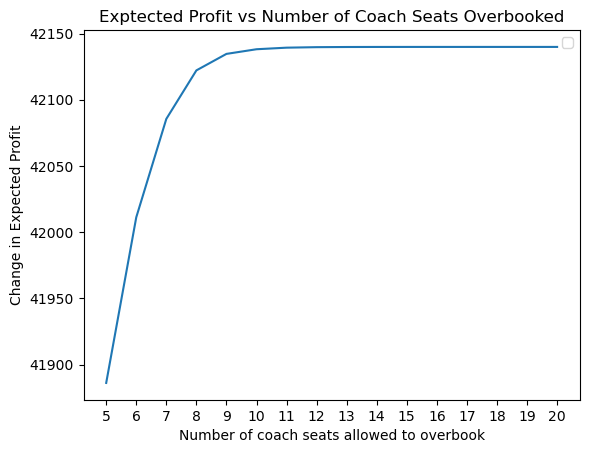

In [209]:
seats_overbooked_range2 = np.arange(5,21)
rev2 = np.zeros(len(seats_overbooked_range2))
for i in range(len(seats_overbooked_range2)):
    opt_choice2, val2 = exp_rev_three_choices(100, 20, seats_overbooked_range2[i])
    rev2[i] = val2[0,0,0]

# Plot of the expected profit with number of seats overbooked in Coach
seats_overbooked_range2 = np.arange(5, 21, 1)
plt.plot(seats_overbooked_range2, rev2)
plt.ylabel('Change in Expected Profit')
plt.xlabel('Number of coach seats allowed to overbook')
plt.title('Exptected Profit vs Number of Coach Seats Overbooked')
plt.xticks(seats_overbooked_range2)
plt.legend()
plt.show()

In [211]:
#Data frame with expected profits for each number of seats overbooked from 5 to 20
rev_df2 = pd.DataFrame(rev2, index=seats_overbooked_range2, columns=['Expected Profit'])
rev_df2.index.name = "seats overbooked"
rev_df2

,Expected Profit
seats overbooked,
5,41886.158624
6,42011.221060
7,42085.536156
8,42122.167269
9,42134.624830
10,42138.140498
11,42139.327940
12,42139.708945
13,42139.831425


Here we can observe that the maximum expected discounted profit is when we allow coach to be oversold by 11 seats since after 11 the change in profit is not so significant and we can avoid increasing more seats to be oversold

### Simulation for first policy (optimum), setting 9 seats to be overbooked

In [182]:
def get_probabilities_and_prices_1(f, price_temp):
    if f == flight_details['F_num']:  # If first class is sold out
        prob_c_key = 'p_cl_fc_soldout' if price_temp in [1, 2] else 'p_ch_fc_soldout'
    else:
        prob_c_key = 'p_cl' if price_temp in [1, 2] else 'p_ch'
    
    prob_f_key = 'p_fl' if price_temp in [1, 3] else 'p_fh'
    
    # Retrieve probabilities and actual prices based on decision
    prob_c, prob_f = [1 - params["demand_probabilities"][prob_c_key], 1 - params["demand_probabilities"][prob_f_key]]
    actual_c, actual_f = [pricing['cl'] if price_temp in [1, 2] else pricing['ch'],
                          pricing['fl'] if price_temp in [1, 3] else pricing['fh']]
    
    return (prob_c, prob_f), (actual_c, actual_f)

overbooking_allowed = 9
n = 100000
params = get_params(100, 20, overbooking_allowed)
num_days_until_takeoff_states, flight_details, pricing, cost_matrix,num_coach_sales_states,num_first_class_sales_states,overbooking_costs = \
    params["num_days_until_takeoff_states"], params["flight_details"], params["pricing"], params["cost_matrix"], params["num_coach_sales_states"], params["num_first_class_sales_states"], params["overbooking_costs"]

cost_matrix = init_costmatrix(num_coach_sales_states, num_first_class_sales_states, flight_details['C_num'], flight_details['F_num'], overbooking_costs, flight_details)

rev_strat1, c_overbook_strat1, pass_off_strat1, overbooking_cost_strat1 = \
    np.zeros(n), np.zeros(n, dtype=bool), np.zeros(n, dtype=bool), np.zeros(n)
opt_dec_strat1, _ = exp_rev_two_choices(100, 20, overbooking_allowed)

for sim in range(n):
    total_rev, c, f = 0, 0, 0

    for i in range(num_days_until_takeoff_states-1):
        price_temp = opt_dec_strat1[c, f, i]
        (prob_c, prob_f), (actual_c, actual_f) = get_probabilities_and_prices_1(f, price_temp)

        c_sale, f_sale = np.random.random() < prob_c if c < opt_dec_strat1.shape[0]-1 else 0, np.random.random() < prob_f if f < 20 else 0
        c += c_sale
        f += f_sale

        total_rev += (c_sale * actual_c + f_sale * actual_f) * flight_details['delta'] ** (i - 1)
    
    # Handling overbooking
    if c > 100:
        c_overbook_strat1[sim] = True
        overbooked_c = sum(np.random.random(c) < 0.95)
        overbooked_f = sum(np.random.random(f) < 0.97)
        overbooking_cost = cost_matrix[overbooked_c, overbooked_f] if overbooked_c > 100 else 0
        total_rev -= overbooking_cost * flight_details['delta'] ** (num_days_until_takeoff_states - 1)
        rev_strat1[sim], overbooking_cost_strat1[sim] = total_rev, overbooking_cost
        pass_off_strat1[sim] = (overbooked_c - 100) > (20 - overbooked_f)

In [214]:
print("On an average the expected profit is:",np.mean(rev_strat1))
print("How often Coach seats are overbooked?:",np.mean(c_overbook_strat1))
print("How often the passengers are bumped off the plane?:",np.mean(pass_off_strat1),"i.e. around 70% of the time")
print("What is the variation in expected profit?:",np.std(rev_strat1))
print("What is the average overbooking cost?:",np.mean(overbooking_cost_strat1))

On an average the expected profit is: 42151.80698807014
How often Coach seats are overbooked?: 1.0
How often the passengers are bumped off the plane?: 0.69964 i.e. around 70% of the time
What is the variation in expected profit?: 934.6863121629227
What is the average overbooking cost?: 987.91075


### Simulation for second policy (optimum), setting 11 seats to be overbooked

In [231]:
def get_probabilities_and_prices_2(f, price_temp):
    if f == flight_details['F_num']:
        p_cl, p_ch = params["demand_probabilities"]["p_cl_fc_soldout"], params["demand_probabilities"]["p_ch_fc_soldout"]
    else:
        p_cl, p_ch = params["demand_probabilities"]["p_cl"], params["demand_probabilities"]["p_ch"]
    p_fl, p_fh = params["demand_probabilities"]["p_fl"], params["demand_probabilities"]["p_fh"]

    # Map price_temp to probabilities and actual prices
    price_map = {
        1: ([1-p_cl, 1-p_fl], [pricing["cl"], pricing["fl"]]),
        2: ([1-p_cl, 1-p_fh], [pricing["cl"], pricing["fh"]]),
        3: ([1-p_ch, 1-p_fl], [pricing["ch"], pricing["fl"]]),
        4: ([1-p_ch, 1-p_fh], [pricing["ch"], pricing["fh"]]),
        5: ([0, 1-p_fl], [0, pricing["fl"]]),  # No seats offered for coach, low price for first class
        6: ([0, 1-p_fh], [0, pricing["fh"]])   # No seats offered for coach, high price for first class
    }
    return price_map.get(price_temp, ([0, 0], [0, 0]))  # Defaults to no sale

overbooking_allowed = 11
n = 100000
params = get_params(100, 20, overbooking_allowed)
num_days_until_takeoff_states, flight_details, pricing, cost_matrix,num_coach_sales_states,num_first_class_sales_states,overbooking_costs = \
    params["num_days_until_takeoff_states"], params["flight_details"], params["pricing"], params["cost_matrix"], params["num_coach_sales_states"], params["num_first_class_sales_states"], params["overbooking_costs"]


rev_strat2, c_overbook_strat2, pass_off_strat2, overbooking_cost_strat2 = \
    np.zeros(n), np.zeros(n, dtype=bool), np.zeros(n, dtype=bool), np.zeros(n)

cost_matrix = init_costmatrix(num_coach_sales_states, num_first_class_sales_states, flight_details['C_num'], flight_details['F_num'], overbooking_costs, flight_details)
opt_dec_strat2, _ = exp_rev_three_choices(100, 20, overbooking_allowed)

for sim in range(n):
    total_rev, c, f = 0, 0, 0
    c_seats, f_seats, rev_list = np.zeros(num_days_until_takeoff_states-1), np.zeros(num_days_until_takeoff_states-1), np.zeros(num_days_until_takeoff_states-1)

    for i in range(num_days_until_takeoff_states-1):
        price_temp = opt_dec_strat2[c, f, i]
        (prob_c, prob_f), (actual_c, actual_f) = get_probabilities_and_prices_2(f, price_temp)

        c_sale, f_sale = np.random.random() < prob_c if c < opt_dec_strat2.shape[0]-1 else 0, np.random.random() < prob_f if f < 20 else 0
        c += c_sale
        f += f_sale
        total_rev += (c_sale * actual_c + f_sale * actual_f) * flight_details['delta'] ** (i-1)
        c_seats[i], f_seats[i], rev_list[i] = c, f, total_rev

    if c > 100:
        c_overbook_strat2[sim] = True
        actual_c, actual_f = sum(np.random.random(c) < 0.95), sum(np.random.random(f) < 0.97)
        overbooking_cost = cost_matrix[actual_c, actual_f] if actual_c > 100 else 0
        total_rev -= overbooking_cost * flight_details['delta'] ** (num_days_until_takeoff_states-1)
        rev_strat2[sim], overbooking_cost_strat2[sim] = total_rev, overbooking_cost
        pass_off_strat2[sim] = (actual_c - 100) > (20 - actual_f)

In [232]:
print("On an average the expected profit is:",np.mean(rev_strat2))
print("How often Coach seats are overbooked?:",np.mean(c_overbook_strat2))
print("How often the passengers are bumped off the plane?:",np.mean(pass_off_strat2),"i.e. around 71% of the time")
print("What is the variation in expected profit?:",np.std(rev_strat2))
print("What is the average overbooking cost?:",np.mean(overbooking_cost_strat2))

On an average the expected profit is: 42166.047558480735
How often Coach seats are overbooked?: 1.0
How often the passengers are bumped off the plane?: 0.71374 i.e. around 71% of the time
What is the variation in expected profit?: 940.3875919812954
What is the average overbooking cost?: 1026.00125


### Comparison of both methods

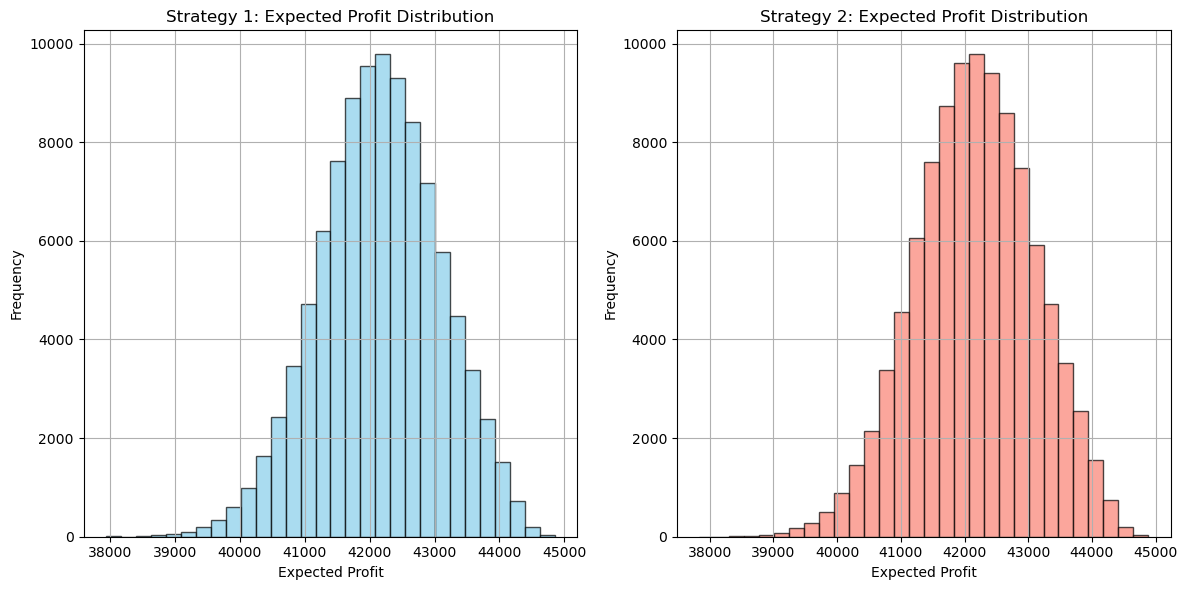

In [233]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(rev_strat1, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Strategy 1: Expected Profit Distribution')
plt.xlabel('Expected Profit')
plt.ylabel('Frequency')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.hist(rev_strat2, bins=30, color='salmon', edgecolor='black', alpha=0.7)
plt.title('Strategy 2: Expected Profit Distribution')
plt.xlabel('Expected Profit')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

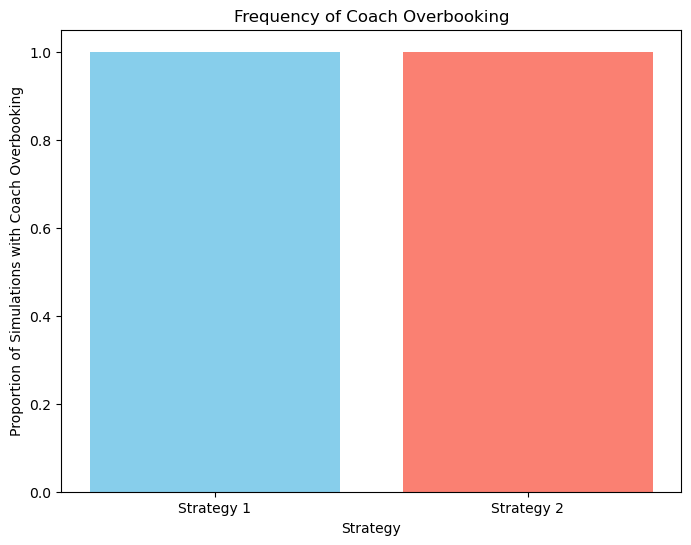

In [234]:
# Calculate the proportion of coach overbooking for both strategies
overbook_freq_strat1 = np.mean(c_overbook_strat1)
overbook_freq_strat2 = np.mean(c_overbook_strat2)

# Plot bar plots for coach overbooking frequency
plt.figure(figsize=(8, 6))

plt.bar(['Strategy 1', 'Strategy 2'], [overbook_freq_strat1, overbook_freq_strat2], color=['skyblue', 'salmon'])
plt.title('Frequency of Coach Overbooking')
plt.xlabel('Strategy')
plt.ylabel('Proportion of Simulations with Coach Overbooking')

plt.show()

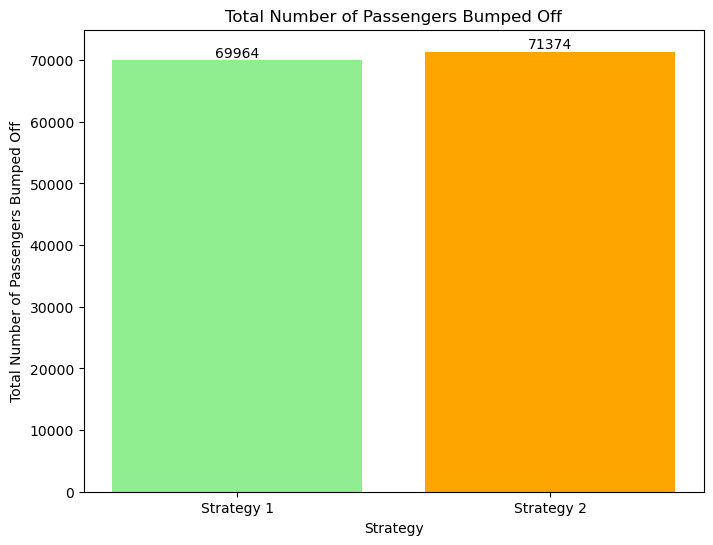

In [235]:
pass_off_total_strat1 = np.sum(pass_off_strat1)
pass_off_total_strat2 = np.sum(pass_off_strat2)

# Plot bar plots for total passengers bumped off
plt.figure(figsize=(8, 6))

bar_heights = [pass_off_total_strat1, pass_off_total_strat2]
bar_labels = ['Strategy 1', 'Strategy 2']

bars = plt.bar(bar_labels, bar_heights, color=['lightgreen', 'orange'])
plt.title('Total Number of Passengers Bumped Off')
plt.xlabel('Strategy')
plt.ylabel('Total Number of Passengers Bumped Off')

# Add text annotations
for bar, label in zip(bars, bar_heights):
    plt.text(bar.get_x() + bar.get_width() / 2, label, str(label), ha='center', va='bottom')

plt.show()

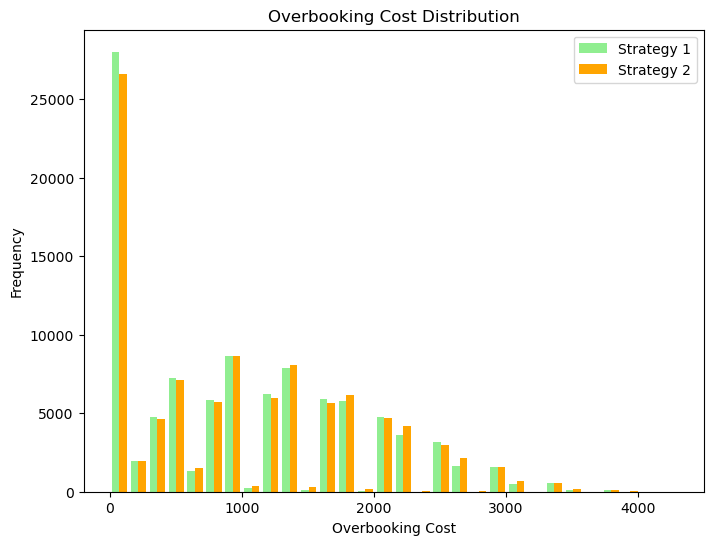

In [236]:
# Plotting Overbooking Cost for both strategies
plt.figure(figsize=(8, 6))

# Plotting the histogram
plt.hist([overbooking_cost_strat1, overbooking_cost_strat2], bins=30, color=['lightgreen', 'orange'], label=['Strategy 1', 'Strategy 2'])

plt.title('Overbooking Cost Distribution')
plt.xlabel('Overbooking Cost')
plt.ylabel('Frequency')
plt.legend()

plt.show()
